### Import

In [1]:
import os
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_distances
import random
from sklearn.model_selection import train_test_split
import umap
import pandas as pd
from torch import nn

c:\Users\danyo\miniconda3\envs\hecto\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Config

In [2]:
CFG = {
    'IMG_SIZE': 224,
    'BATCH_SIZE': 64,
    'EPOCHS': 20,
    'LEARNING_RATE': 1e-4,
    'SEED' : 42
}

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Seed 고정 함수

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(CFG['SEED']) # Seed 고정

### Custom Dataset

In [5]:
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None, is_test=False):
        self.root_dir = root_dir
        self.transform = transform
        self.is_test = is_test
        self.samples = []

        if is_test:
            # 테스트셋: 라벨 없이 이미지 경로만 저장
            for fname in sorted(os.listdir(root_dir)):
                if fname.lower().endswith(('.jpg')):
                    img_path = os.path.join(root_dir, fname)
                    self.samples.append((img_path,))
        else:
            # 학습셋: 클래스별 폴더 구조에서 라벨 추출
            self.classes = sorted(os.listdir(root_dir))
            self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

            for cls_name in self.classes:
                cls_folder = os.path.join(root_dir, cls_name)
                for fname in os.listdir(cls_folder):
                    if fname.lower().endswith(('.jpg')):
                        img_path = os.path.join(cls_folder, fname)
                        label = self.class_to_idx[cls_name]
                        self.samples.append((img_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        if self.is_test:
            img_path = self.samples[idx][0]
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, img_path  # 테스트셋은 라벨 없으니 이미지+경로
        else:
            img_path, label = self.samples[idx]
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, label, img_path  # 학습셋은 이미지, 라벨, 경로 모두 반환

### Transform 설정

In [6]:
train_transform = transforms.Compose([
    transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

### Dataset 구성

In [7]:
train_root = './data/train'
test_root = './data/test'

### Load Full Dataset

In [8]:
# 전체 데이터셋 로드
full_dataset = CustomImageDataset(train_root, transform=None)
print(f"총 이미지 수: {len(full_dataset)}")

targets = [label for _, label in full_dataset.samples]
class_names = full_dataset.classes

# Stratified Split
train_idx, val_idx = train_test_split(
    range(len(targets)), test_size=0.2, stratify=targets, random_state=42
)

# Subset + transform 각각 적용
train_dataset = Subset(CustomImageDataset(train_root, transform=train_transform), train_idx)
val_dataset = Subset(CustomImageDataset(train_root, transform=val_transform), val_idx)

print(f'train 이미지 수: {len(train_dataset)}, valid 이미지 수: {len(val_dataset)}')

# DataLoader 정의
train_loader = DataLoader(train_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False)

# 모델 정의
class BaseModel(nn.Module):
    def __init__(self, num_classes: int):
        super(BaseModel, self).__init__()
        self.backbone = models.resnet18(pretrained=False)
        self.feature_dim = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()
        self.head = nn.Linear(self.feature_dim, num_classes)

    def forward(self, x):
        x = self.backbone(x)
        x = self.head(x)
        return x

총 이미지 수: 33137
train 이미지 수: 26509, valid 이미지 수: 6628


### Feature 추출 함수

In [9]:
def extract_features(model, dataloader, device):
    model.eval()
    all_features, all_labels, all_paths = [], [], []

    with torch.no_grad():
        for imgs, labels, paths in tqdm(dataloader, desc="Extracting features"):
            imgs = imgs.to(device)
            feats = model(imgs)
            all_features.append(feats.cpu())
            all_labels.extend(labels)
            all_paths.extend(paths)

    features = torch.cat(all_features).numpy()
    return features, np.array(all_labels), np.array(all_paths)

### 이상치 탐지 함수

In [10]:
def get_outliers(features, labels, paths, top_n=5):
    outlier_info = []

    for cls in np.unique(labels):
        cls_idxs = np.where(labels == cls)[0]
        cls_feats = features[cls_idxs]

        dist_matrix = cosine_distances(cls_feats)
        mean_dists = dist_matrix.mean(axis=1)

        top_outlier_idxs = mean_dists.argsort()[::-1][:top_n]
        for idx in top_outlier_idxs:
            outlier_info.append({
                "class": cls,
                "image_path": paths[cls_idxs[idx]],
                "mean_cosine_distance": mean_dists[idx]
            })

    return pd.DataFrame(outlier_info)

### UMAP 시각화 함수

In [11]:
def visualize_umap(features, labels, seed=42, title="UMAP projection"):
    reducer = umap.UMAP(random_state=seed)
    embedding = reducer.fit_transform(features)

    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='tab20', s=5, alpha=0.7)
    plt.colorbar(scatter, label="Class Label")
    plt.title(title)
    plt.show()

### RUN

c:\Users\danyo\miniconda3\envs\hecto\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\danyo\miniconda3\envs\hecto\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Extracting features: 100%|██████████| 518/518 [02:24<00:00,  3.58it/s]
c:\Users\danyo\miniconda3\envs\hecto\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\danyo\miniconda3\envs\hecto\Lib\site-packages\umap\umap_.

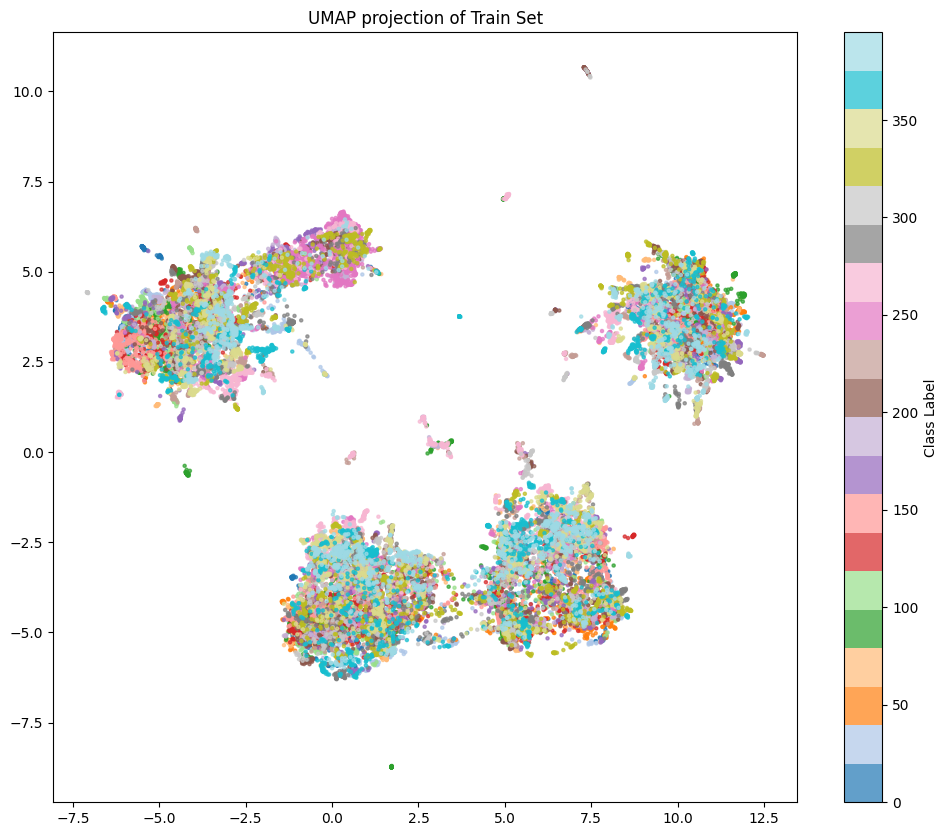

   class                                         image_path  \
0      0  ./data/train\1시리즈_F20_2013_2015\1시리즈_F20_2013_...   
1      0  ./data/train\1시리즈_F20_2013_2015\1시리즈_F20_2013_...   
2      0  ./data/train\1시리즈_F20_2013_2015\1시리즈_F20_2013_...   
3      0  ./data/train\1시리즈_F20_2013_2015\1시리즈_F20_2013_...   
4      0  ./data/train\1시리즈_F20_2013_2015\1시리즈_F20_2013_...   

   mean_cosine_distance  
0              0.238057  
1              0.212728  
2              0.198026  
3              0.197926  
4              0.190261  


In [12]:
# 모델 로드 (ResNet18 기반 feature extractor)
feature_extractor = models.resnet18(pretrained=True)
feature_extractor.fc = nn.Identity()
feature_extractor = feature_extractor.to(device)

# 전체 학습 데이터셋 로딩
full_dataset_for_feat = CustomImageDataset(train_root, transform=val_transform)
full_loader = DataLoader(full_dataset_for_feat, batch_size=CFG['BATCH_SIZE'], shuffle=False)

# Feature 추출
features, labels, paths = extract_features(feature_extractor, full_loader, device)

# 시각화
visualize_umap(features, labels, seed=CFG['SEED'], title="UMAP projection of Train Set")

# 이상치 추출
outlier_df = get_outliers(features, labels, paths, top_n=5)
print(outlier_df.head())

# 저장
outlier_df.to_csv("outlier_candidates.csv", index=False)

### 이상치 상위 500개 추출

In [13]:
import pandas as pd

# CSV 불러오기
df = pd.read_csv("outlier_candidates.csv")

# mean_cosine_distance 기준 내림차순 정렬 후 상위 500개 추출
top_500 = df.sort_values(by="mean_cosine_distance", ascending=False).head(500)

# 새로운 CSV로 저장
top_500.to_csv("top500_outliers.csv", index=False)

print("상위 500개 이상치 저장 완료: top500_outliers.csv")

상위 500개 이상치 저장 완료: top500_outliers.csv
